# Find natural neighbors visual test

A triangle is a natural neighbor for a point if the <a href=https://en.wikipedia.org/wiki/Circumscribed_circle>circumscribed circle</a> of the triangle contains that point.  It is important that we correctly grab the correct triangles for each point before proceeding with the interpolation.

Algorithmically:

1) We place all of the grid points in a KDTree.  These provide worst-case O(n) time complexity for spatial searches.

2) We generate a <a href=http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.Delaunay.html>Delaunay Triangulation</a> using the locations of the provided observations.

3) For each triangle, we calculate its circumcenter and circumradius.  Using KDTree, we then assign each grid a triangle that has a circumcenter within a circumradius of the grid's location.

4) The resulting dictionary uses the grid index as a key and a set of natural neighbor triangles in the form of triangle codes from the Delaunay triangulation.  This dictionary is then iterated through to calculate interpolation values.

5) We then traverse the ordered natural neighbor edge vertices for a particular grid cell in groups of 3 (n - 1, n, n + 1), and perform calculations to generate proportional polygon areas.

Circumcenter of (n - 1), n, grid_location

Circumcenter of (n + 1), n, grid_location

Determine what existing circumcenters (ie, Delaunay circumcenters) are associated with vertex n, and add those as polygon vertices.  Calculate the area of this polygon.

6) Increment the current edges to be checked, i.e.:

n - 1 = n, n = n + 1, n + 1 = n + 2

7) Repeat steps 5 & 6 until all of the edge combinations of 3 have been visited. 

8) Repeat steps 4 through 7 for each grid cell.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

from metpy.mapping.triangles import *
from metpy.mapping.interpolation import nn_point

from scipy.spatial import cKDTree, Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d

For a test case, we generate 10 random points and observations, where the observation values are just the x coordinate value times the y coordinate value divided by 1000.

We then create two test points (grid 0 & grid 1) at which we want to estimate a value using natural neighbor interpolation.

The locations of these observations are then used to generate a Delaunay triangulation.

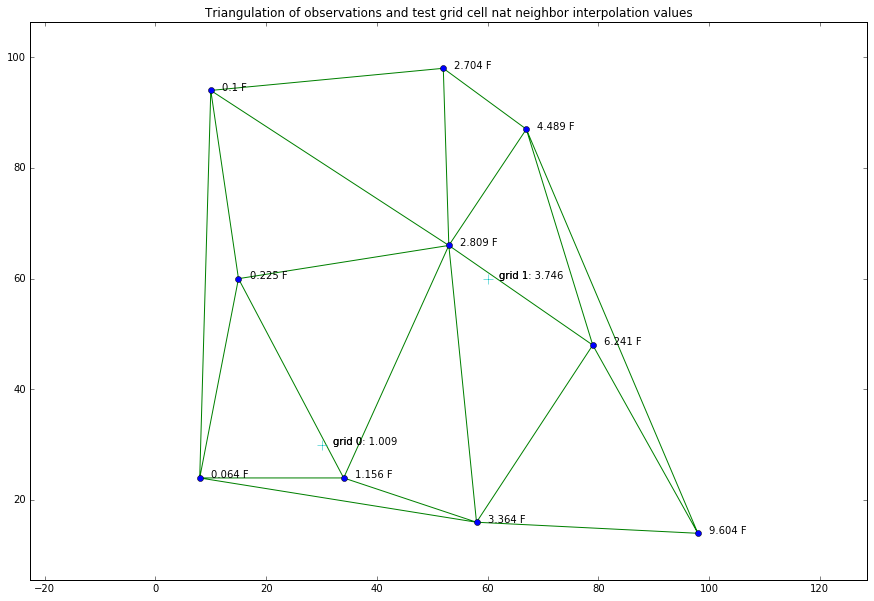

In [2]:
np.random.seed(100)

pts = np.random.randint(0, 100, (10, 2))
xp = pts[:, 0]
yp = pts[:, 1]
z = (pts[:, 0] * pts[:, 0]) / 1000

tri = Delaunay(pts)


delaunay_plot_2d(tri)

for i in range(len(z)):
    plt.annotate(str(z[i]) + " F", xy=(pts[i, 0]+2, pts[i, 1]))

sim_gridx = [30, 60]
sim_gridy = [30, 60]

plt.plot(sim_gridx, sim_gridy, "+", markersize=10)

plt.annotate("grid 0", xy = (sim_gridx[0]+2, sim_gridy[0]))
plt.annotate("grid 1", xy = (sim_gridx[1]+2, sim_gridy[1]))

plt.axes().set_aspect('equal', 'datalim')
plt.title("Triangulation of observations and test grid cell nat neighbor interpolation values")

members, tri_info = find_natural_neighbors(tri, list(zip(sim_gridx, sim_gridy)))

val = nn_point(xp, yp, z, [sim_gridx[0], sim_gridy[0]], tri, members[0], tri_info)
plt.annotate("grid 0: " + ("%.3f" % val), xy = (sim_gridx[0]+2, sim_gridy[0]))

val = nn_point(xp, yp, z, [sim_gridx[1], sim_gridy[1]], tri, members[1], tri_info)
plt.annotate("grid 1: " + ("%.3f" % val), xy = (sim_gridx[1]+2, sim_gridy[1]))

In [3]:
xp, yp, z

(array([ 8, 67, 79, 10, 52, 53, 98, 34, 15, 58]),
 array([24, 87, 48, 94, 98, 66, 14, 24, 60, 16]),
 array([ 0.064,  4.489,  6.241,  0.1  ,  2.704,  2.809,  9.604,  1.156,
         0.225,  3.364]))

Using the circumcenter and circumcircle radius information from metpy.mapping.triangle.find_natural_neighbors, we can visualy
examine the results to see if they are correct.

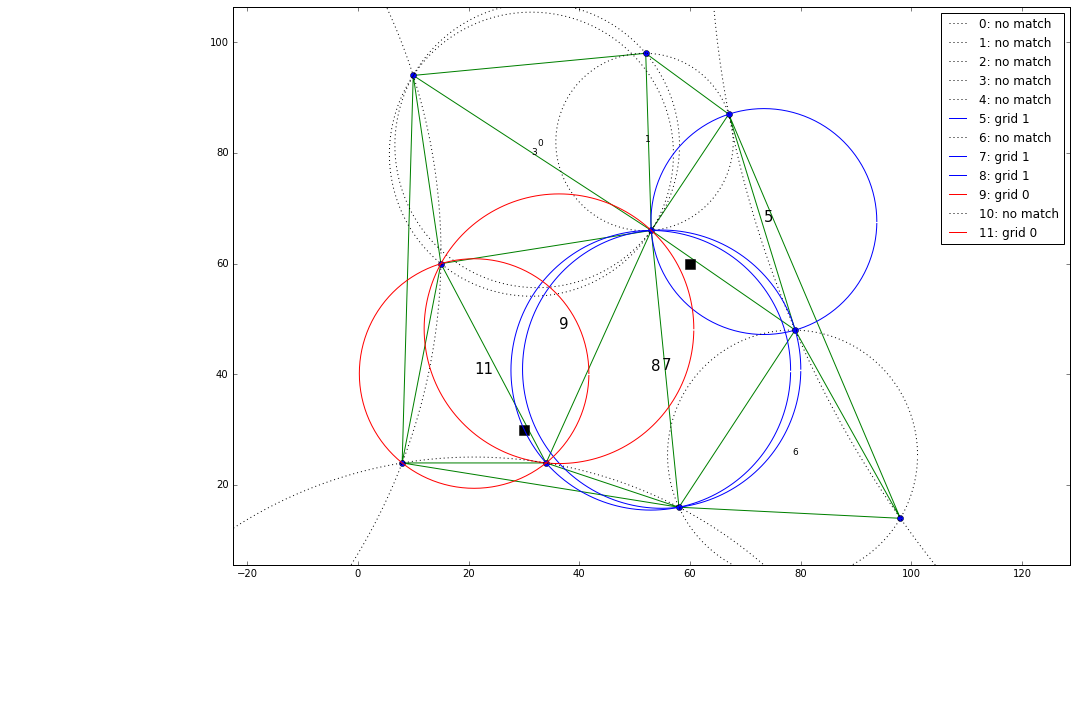

In [4]:
from metpy.mapping import triangles
from metpy.mapping.interpolation import nn_point

def draw_circle(x, y, r, m, label):
    
    nx = x + r * np.cos(np.deg2rad(list(range(360))))
    ny = y + r * np.sin(np.deg2rad(list(range(360))))

    plt.plot(nx, ny, m, label=label)
    
members, tri_info = triangles.find_natural_neighbors(tri, list(zip(sim_gridx, sim_gridy)))

delaunay_plot_2d(tri)


plt.plot(sim_gridx, sim_gridy, "ks", markersize=10)

for i, info in tri_info.items():
    
    x_t = info['cc'][0]
    y_t = info['cc'][1]
    
    if i in members[1] and i in members[0]:

        draw_circle(x_t, y_t, info['r'], 'm-', str(i) + ": grid 1 & 2")

        plt.annotate(str(i), xy=(x_t, y_t), fontsize=15)
    
    elif i in members[0]:

        draw_circle(x_t, y_t, info['r'], 'r-', str(i) + ": grid 0")

        plt.annotate(str(i), xy=(x_t, y_t), fontsize=15)
        
    elif i in members[1]:

        draw_circle(x_t, y_t, info['r'], 'b-', str(i) + ": grid 1")

        plt.annotate(str(i), xy=(x_t, y_t), fontsize=15)
        
    else:
        
        draw_circle(x_t, y_t, info['r'], 'k:', str(i) + ": no match")

        plt.annotate(str(i), xy=(x_t, y_t), fontsize=9)

plt.axes().set_aspect('equal', 'datalim')
plt.legend()

Whaaa.... the circle from triangle 8 looks pretty darn close.. why isn't grid 0 included in that circle?

In [5]:
from scipy.spatial.distance import euclidean

x_t, y_t = tri_info[8]['cc']
r = tri_info[8]['r']

print("Distance between grid0 and Triangle 8's circumcenter:", euclidean([x_t,y_t], [sim_gridx[0], sim_gridy[0]]))
print("Triangle 8's circumradius:", r)

Distance between grid0 and Triangle 8's circumcenter: 25.30650398368644
Triangle 8's circumradius: 25.258767799971732


Lets do a manual check of the above interpolation value for grid 0 (southernmost grid)

Grab the circumcenters and radii for natural neighbors

In [6]:
cc = np.array([tri_info[m]['cc'] for m in members[0]])
r = np.array([tri_info[m]['r'] for m in members[0]])

print("circumcenters:\n", cc)
print("radii\n", r)

circumcenters:
 [[ 36.32995951  48.24358974]
 [ 21.          40.15277778]]
radii
 [ 24.35529419  20.73432492]


Draw the natural neighbor triangles and their circumcenters. Also plot a <a href=http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.spatial.Voronoi.html>voronoi diagram</a> which serves as a complementary (but not neccesary) spatial data structure that we use here simply to show areal ratios.  Notice that the two natural neighbor triangle circumcenters are also vertices in the voronoi plot (green dots), and the observations are in the the polygons (blue dots).

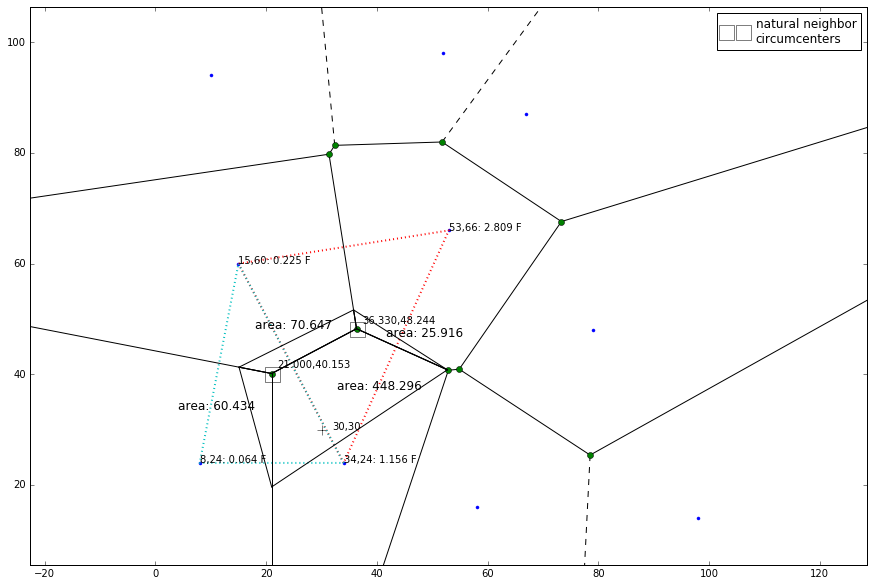

In [7]:
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from metpy.mapping import polygons

vor = Voronoi(list(zip(xp, yp)))
voronoi_plot_2d(vor)

nn_ind = np.array([0, 5, 7, 8])

z_0 = z[nn_ind]
x_0 = xp[nn_ind]
y_0 = yp[nn_ind]

for i in range(len(nn_ind)):
    lab = str(x_0[i]) + "," + str(y_0[i]) + ": " + ("%.3f" % z_0[i]) + " F"
    plt.annotate(lab, xy=(x_0[i], y_0[i])) 

plt.plot(sim_gridx[0], sim_gridy[0], "k+", markersize=10)
plt.annotate(str(sim_gridx[0]) + "," + str(sim_gridy[0]), xy=(sim_gridx[0]+2, sim_gridy[0]))

def plot_triangle(triangle):
    x = [triangle[0,0], triangle[1,0], triangle[2,0], triangle[0,0]]
    y = [triangle[0,1], triangle[1,1], triangle[2,1], triangle[0,1]]
    
    plt.plot(x, y, ":", linewidth=2)
    
tris = tri.points[tri.simplices[members[0]]]

plt.plot(cc[:, 0], cc[:, 1], "ks", markersize=15, fillstyle='none', label="natural neighbor\ncircumcenters")

for i in range(len(cc)):
    
    lab = ("%.3f" % cc[i, 0]) + "," + ("%.3f" % cc[i, 1])
    plt.annotate(lab, xy=(cc[i, 0]+1, cc[i, 1]+1))

for t in tris:
    plot_triangle(t)
    
plt.legend()
plt.axes().set_aspect('equal', 'datalim')

polygon = list()

polygon.append(cc[0])
#polygon.append(cc[1])

cc1 = circumcenter([53, 66], [15, 60], [30, 30])
cc2 = circumcenter([34, 24], [53, 66], [30, 30])

polygon.append(cc1)
polygon.append(cc2)


pts = np.array([polygon[i] for i in ConvexHull(polygon).vertices])
A = polygons.area(pts)

for i in range(len(pts)):
    
    plt.plot([pts[i][0], pts[(i+1)%len(pts)][0]], [pts[i][1], pts[(i+1)%len(pts)][1]], 'k-')

avex = np.mean(pts[:,0])
avey = np.mean(pts[:,1])
plt.annotate("area: " + ("%.3f" % A), xy=(avex, avey), fontsize=12)

polygon = list()

polygon.append(cc[0])
polygon.append(cc[1])

cc1 = circumcenter([53, 66], [15, 60], [30, 30])
cc2 = circumcenter([15, 60], [8, 24], [30, 30])

polygon.append(cc1)
polygon.append(cc2)


pts = np.array([polygon[i] for i in ConvexHull(polygon).vertices])
A = polygons.area(pts)

for i in range(len(pts)):
    
    plt.plot([pts[i][0], pts[(i+1)%len(pts)][0]], [pts[i][1], pts[(i+1)%len(pts)][1]], 'k-')
    
avex = np.mean(pts[:,0])
avey = np.mean(pts[:,1])
plt.annotate("area: " + ("%.3f" % A), xy=(avex-9, avey+3), fontsize=12)

polygon = list()

#polygon.append(cc[0])
polygon.append(cc[1])

cc1 = circumcenter([8, 24], [34, 24], [30, 30])
cc2 = circumcenter([15, 60], [8, 24], [30, 30])

polygon.append(cc1)
polygon.append(cc2)


pts = np.array([polygon[i] for i in ConvexHull(polygon).vertices])
A = polygons.area(pts)

for i in range(len(pts)):
    
    plt.plot([pts[i][0], pts[(i+1)%len(pts)][0]], [pts[i][1], pts[(i+1)%len(pts)][1]], 'k-')
    
avex = np.mean(pts[:,0])
avey = np.mean(pts[:,1])
plt.annotate("area: " + ("%.3f" % A), xy=(avex-15, avey), fontsize=12)


polygon = list()

polygon.append(cc[0])
polygon.append(cc[1])

cc1 = circumcenter([8, 24], [34, 24], [30, 30])
cc2 = circumcenter([34, 24], [53, 66], [30, 30])

polygon.append(cc1)
polygon.append(cc2)


pts = np.array([polygon[i] for i in ConvexHull(polygon).vertices])
A = polygons.area(pts)

for i in range(len(pts)):
    
    plt.plot([pts[i][0], pts[(i+1)%len(pts)][0]], [pts[i][1], pts[(i+1)%len(pts)][1]], 'k-')
    
avex = np.mean(pts[:,0])
avey = np.mean(pts[:,1])
plt.annotate("area: " + ("%.3f" % A), xy=(avex, avey), fontsize=12)

Put all of the generated polygon areas and their affiliated values in arrays.

Calculate the total area of all of the generated polygons.

In [8]:
areas = np.array([60.434, 448.296, 25.916, 70.647])
values = np.array([0.064, 1.156, 2.809, 0.225])

total_area = np.sum(areas)

total_area

605.29300000000012

For each polygon area, calculate its percent of total area.

In [9]:
proportions = areas / np.sum(areas)

proportions

array([ 0.09984256,  0.74062644,  0.04281563,  0.11671538])

Multiply the percent of total area by the respective values.

In [10]:
contributions = proportions * values

contributions

array([ 0.00638992,  0.85616417,  0.1202691 ,  0.02626096])

The sum of this array is the interpolation value!

In [11]:
interpolation_value = np.sum(contributions)
function_output = nn_point(xp, yp, z, [sim_gridx[0], sim_gridy[0]], tri, members[0], tri_info)

interpolation_value, function_output

(1.0090841476772403, 1.0090842444256041)

The values are slightly different due to truncating the area values in the above visual example to the 3rd decimal place.